<a href="https://colab.research.google.com/github/zaccleong/Used_Car_Price_Prediction/blob/main/Used_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
#import sweetviz as sv
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

In [ ]:
car_raw = pd.read_csv('cars.csv')

In [ ]:
car_raw.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,...,True,False,True,True,False,False,False,False,True,7


In [ ]:
print("Data type : ", type(car_raw))
print("Data dims : ", car_raw.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (38531, 30)


In [ ]:
car_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38531 entries, 0 to 38530
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  38531 non-null  object 
 1   model_name         38531 non-null  object 
 2   transmission       38531 non-null  object 
 3   color              38531 non-null  object 
 4   odometer_value     38531 non-null  int64  
 5   year_produced      38531 non-null  int64  
 6   engine_fuel        38531 non-null  object 
 7   engine_has_gas     38531 non-null  bool   
 8   engine_type        38531 non-null  object 
 9   engine_capacity    38521 non-null  float64
 10  body_type          38531 non-null  object 
 11  has_warranty       38531 non-null  bool   
 12  state              38531 non-null  object 
 13  drivetrain         38531 non-null  object 
 14  price_usd          38531 non-null  float64
 15  is_exchangeable    38531 non-null  bool   
 16  location_region    385

# 1.0 Cleaning the dataset
#### Removing unused variables and invalid data points

### 1.1 : 'feature_0' to 'feature_9' and 'engine_has_gas', 'is_exchangeable', 'up_counter' are variables that we deem highly unrelated to the sale price of the vehicle

In [ ]:
#Removing variables then we do not intend to use
car_cleaned = car_raw.drop(['feature_0','feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','engine_has_gas','is_exchangeable','up_counter'], axis=1)

### 1.2 : 'state' is removed after we keep the 'owned' cars since we only care about used cars

owned        37723
new            438
emergency      370
Name: state, dtype: int64


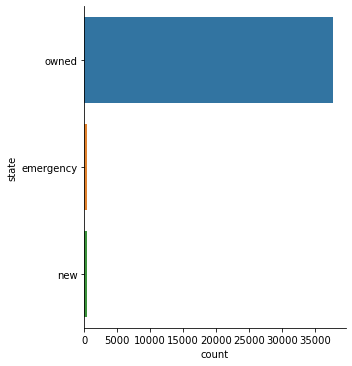

In [ ]:
#Finding out if all the cars in our dataset are "used"
state = pd.DataFrame(car_cleaned['state'])
state.describe()

#Finding out the number of cars in our dataset that are not "used"
print(car_cleaned["state"].value_counts())
sb.catplot(y = "state", data = car_cleaned, kind = "count")

In [ ]:
#Dropping the datapoints with cars that are not used i.e. "owned"
car_cleaned = car_cleaned[car_cleaned.state == 'owned']

In [ ]:
car_cleaned = car_cleaned.drop(['state'], axis=1)

### 1.3 : 'has_warranty' is removed as the used vehicles in our dataset do not come with warranty

False    37649
True        74
Name: has_warranty, dtype: int64


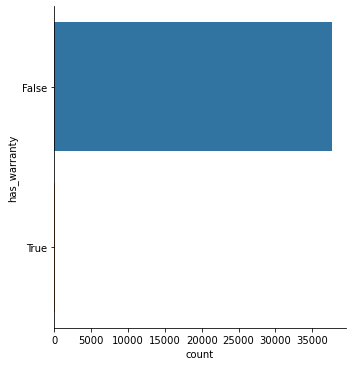

In [ ]:
#Showing the number of cars in our dataset that have no warranty
warranty = pd.DataFrame(car_cleaned['has_warranty'])
warranty.describe()

#Finding out the number of cars in our dataset that have warranty
print(car_cleaned["has_warranty"].value_counts())
sb.catplot(y = "has_warranty", data = car_cleaned, kind = "count")

In [ ]:
car_cleaned = car_cleaned.drop(['has_warranty'], axis=1)

### 1.4 : 'engine_type' is redundant as it is the same as 'engine_fuel' hence it is dropped

In [ ]:
#Renaming renaming both gasoline and gas to petrol as they are the same
car_cleaned = car_cleaned.copy()
car_cleaned['engine_fuel'] = car_cleaned['engine_fuel'].replace(['gas','gasoline'],'petrol')

In [ ]:
car_cleaned = car_cleaned.drop(['engine_type'], axis=1)

### 1.5 : Removing outliers in 'price_usd'

In [ ]:
#Checking for outliers in prices
price=pd.DataFrame(car_cleaned['price_usd'])
price.describe()

,price_usd
count,37723.000000
mean,6473.964881
std,6066.784518
min,1.000000
25%,2150.000000
50%,4750.000000
75%,8800.000000
max,50000.000000


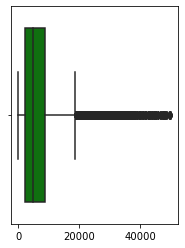

In [ ]:
plt.figure(figsize=(3,4))
sb.boxplot(price, orient = "h", color = 'g')

In [ ]:
#Removing used cars with to high or too low prices
car_cleaned = car_cleaned[(car_cleaned.price_usd < 575000) & (car_cleaned.price_usd > 1000)]
price = pd.DataFrame(car_cleaned['price_usd'])
price.describe()

,price_usd
count,33944.000000
mean,7118.474129
std,6062.247462
min,1001.000000
25%,2900.000000
50%,5490.000000
75%,9400.000000
max,50000.000000


### 1.6 : Removing outliers in 'odometer_value'

In [ ]:
odometer=pd.DataFrame(car_cleaned['odometer_value'])
odometer.describe

<bound method NDFrame.describe of        odometer_value
0              190000
1              290000
2              402000
3               10000
4              280000
...               ...
38526          290000
38527          321000
38528          777957
38529           20000
38530          297729

[33944 rows x 1 columns]>

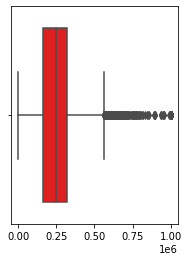

In [ ]:
#Checking for outliers in odometer values
plt.figure(figsize=(3,4))
sb.boxplot(odometer, orient = "h", color = 'r')

In [ ]:
#Removing used cars with to high or too low odometer values
car_cleaned = car_cleaned[(car_cleaned.odometer_value < 600000) & (car_cleaned.odometer_value > 1000)]
odometer = pd.DataFrame(car_cleaned['odometer_value'])
odometer.describe()

,odometer_value
count,33281.000000
mean,242880.471110
std,111744.689053
min,1085.000000
25%,160000.000000
50%,244000.000000
75%,320000.000000
max,599999.000000


### 1.7 : Removing 'year_produced' and adding 'age' as it is more appropriate

In [ ]:
#Converting year produced to age of car so its easier to work with
car_cleaned = car_cleaned.copy()
car_cleaned.loc[:,'age'] = 2020 - car_cleaned['year_produced']

In [ ]:
car_cleaned = car_cleaned.drop(['year_produced'], axis=1)

### 1.8 : Removing null points in the dataset

In [ ]:
#Checking for missing values in the dataset
car_cleaned.isnull().sum()

manufacturer_name     0
model_name            0
transmission          0
color                 0
odometer_value        0
engine_fuel           0
engine_capacity      10
body_type             0
drivetrain            0
price_usd             0
location_region       0
number_of_photos      0
duration_listed       0
age                   0
dtype: int64

In [ ]:
#Dropping datapoints with missing engine_capacity values
car_cleaned = car_cleaned[car_cleaned.engine_capacity.notnull()]

### 1.9 : Renaming 'mechanical' to 'manual' in 'transmission' as it is more apt

In [ ]:
car_cleaned['transmission'] = car_cleaned['transmission'].replace(['mechanical'],'manual')

### Preparing the data set for the models later

In [ ]:
#Shuffling the datasets for the train and test sets to be random
car_shuffled = car_cleaned.sample(frac=1).reset_index(drop=True)
car_shuffled.head()

,manufacturer_name,model_name,transmission,color,odometer_value,engine_fuel,engine_capacity,body_type,drivetrain,price_usd,location_region,number_of_photos,duration_listed,age
0,Opel,Vectra,manual,other,395892,petrol,1.6,hatchback,front,2250.0,Минская обл.,16,34,23
1,Citroen,Xantia,manual,black,30000,diesel,2.0,hatchback,front,2500.0,Минская обл.,5,128,21
2,Ford,Focus,manual,blue,111111,petrol,1.8,sedan,front,2450.0,Могилевская обл.,15,222,21
3,Toyota,Avensis,manual,green,490000,petrol,2.0,universal,front,3700.0,Брестская обл.,4,57,19
4,Renault,Scenic,manual,silver,225000,diesel,1.5,minivan,front,7500.0,Витебская обл.,8,35,11


In [ ]:
#Extracting numeric variables
car_num_shuffled = pd.DataFrame(car_shuffled[['odometer_value','age','engine_capacity','price_usd','number_of_photos','duration_listed']])
car_num_shuffled.head()

,odometer_value,age,engine_capacity,price_usd,number_of_photos,duration_listed
0,395892,23,1.6,2250.0,16,34
1,30000,21,2.0,2500.0,5,128
2,111111,21,1.8,2450.0,15,222
3,490000,19,2.0,3700.0,4,57
4,225000,11,1.5,7500.0,8,35


In [ ]:
#Extracting categorical variables including price as we want to compare the categorical data to it
car_cat_shuffled = pd.DataFrame(car_shuffled[['price_usd','manufacturer_name','model_name','transmission','color','engine_fuel','body_type','drivetrain','location_region']])
car_cat_shuffled.head()

,price_usd,manufacturer_name,model_name,transmission,color,engine_fuel,body_type,drivetrain,location_region
0,2250.0,Opel,Vectra,manual,other,petrol,hatchback,front,Минская обл.
1,2500.0,Citroen,Xantia,manual,black,diesel,hatchback,front,Минская обл.
2,2450.0,Ford,Focus,manual,blue,petrol,sedan,front,Могилевская обл.
3,3700.0,Toyota,Avensis,manual,green,petrol,universal,front,Брестская обл.
4,7500.0,Renault,Scenic,manual,silver,diesel,minivan,front,Витебская обл.


In [ ]:
car_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33271 entries, 0 to 38530
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  33271 non-null  object 
 1   model_name         33271 non-null  object 
 2   transmission       33271 non-null  object 
 3   color              33271 non-null  object 
 4   odometer_value     33271 non-null  int64  
 5   engine_fuel        33271 non-null  object 
 6   engine_capacity    33271 non-null  float64
 7   body_type          33271 non-null  object 
 8   drivetrain         33271 non-null  object 
 9   price_usd          33271 non-null  float64
 10  location_region    33271 non-null  object 
 11  number_of_photos   33271 non-null  int64  
 12  duration_listed    33271 non-null  int64  
 13  age                33271 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 3.8+ MB


# 2.0 Exploring the data

### 2.1 : Generating a report on cleaned dataset

In [ ]:
#car_cleaned.head()
#report = sv.analyze([car_cleaned, "price_usd"])

In [ ]:
#report = sv.analyze([car_clean,'price_usd'])
#report.show_html('report.html')

### 2.2 : Analysing Numeric data

In [ ]:
#Summary statistics for numeric variables
car_num_shuffled.describe()

,odometer_value,age,engine_capacity,price_usd,number_of_photos,duration_listed
count,33271.000000,33271.000000,33271.000000,33271.000000,33271.000000,33271.000000
mean,242931.278050,15.905774,2.095308,7157.694582,9.975805,82.254726
std,111721.193161,7.143763,0.693743,6072.823244,6.198746,112.029158
min,1085.000000,1.000000,0.200000,1001.000000,1.000000,0.000000
25%,160000.000000,11.000000,1.600000,2950.000000,6.000000,25.000000
50%,244000.000000,16.000000,2.000000,5500.000000,9.000000,61.000000
75%,320000.000000,21.000000,2.400000,9450.000000,13.000000,91.000000
max,599999.000000,78.000000,7.500000,50000.000000,86.000000,2232.000000


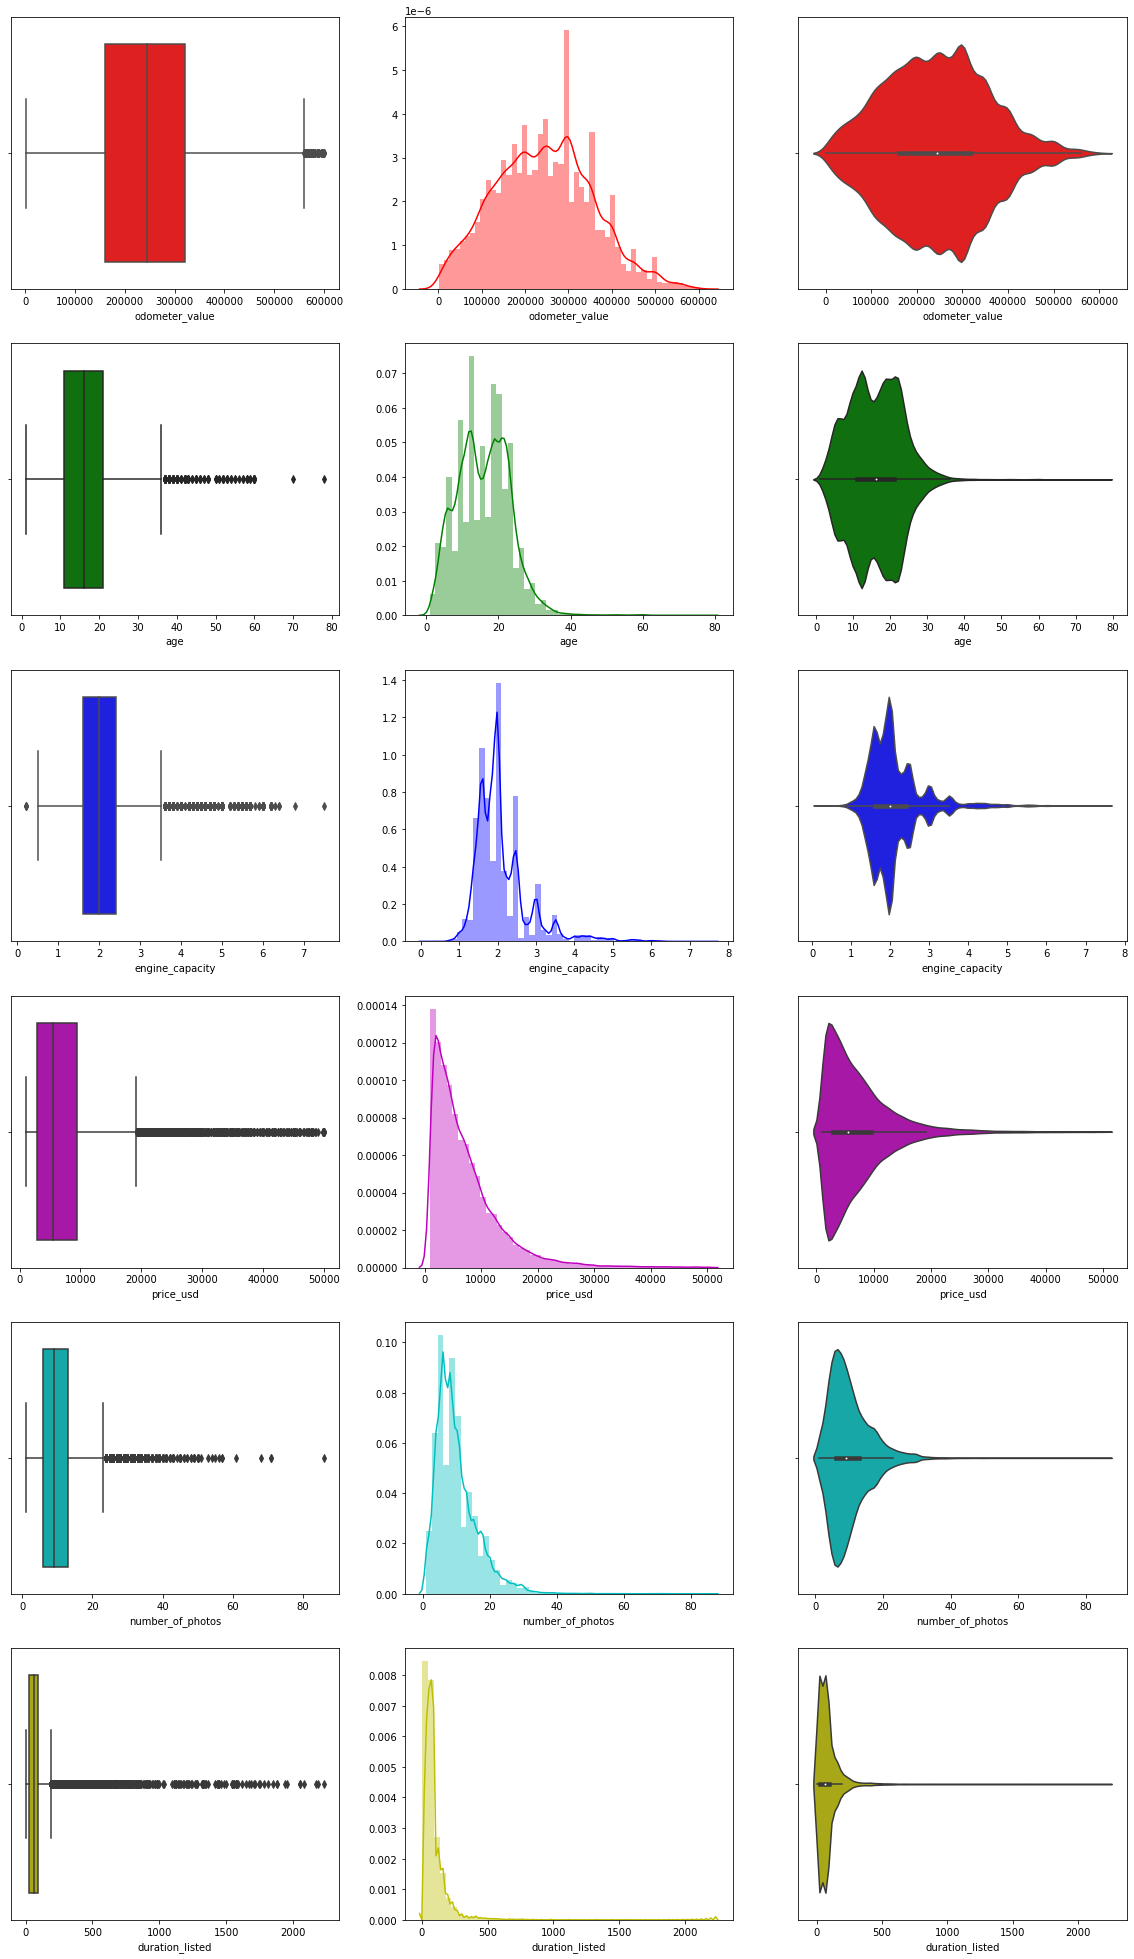

In [ ]:
#Drawing the distributions of the numeric variables
f, axes = plt.subplots(6, 3, figsize=(20, 35))
colors = ["r","g","b","m","c","y"]

count = 0
for var in car_num_shuffled:
    sb.boxplot(car_num_shuffled[var], orient = "h", color = colors[count], ax = axes[count,0])
    sb.distplot(car_num_shuffled[var], color = colors[count], ax = axes[count,1])
    sb.violinplot(car_num_shuffled[var], color = colors[count], ax = axes[count,2])
    count += 1

                  odometer_value       age  engine_capacity  price_usd  \
odometer_value          1.000000  0.590623         0.130779  -0.462279   
age                     0.590623  1.000000         0.061023  -0.680722   
engine_capacity         0.130779  0.061023         1.000000   0.307087   
price_usd              -0.462279 -0.680722         0.307087   1.000000   
number_of_photos       -0.133241 -0.211265         0.093410   0.285831   
duration_listed        -0.020255  0.017106         0.078757   0.043244   

                  number_of_photos  duration_listed  
odometer_value           -0.133241        -0.020255  
age                      -0.211265         0.017106  
engine_capacity           0.093410         0.078757  
price_usd                 0.285831         0.043244  
number_of_photos          1.000000        -0.032793  
duration_listed          -0.032793         1.000000  


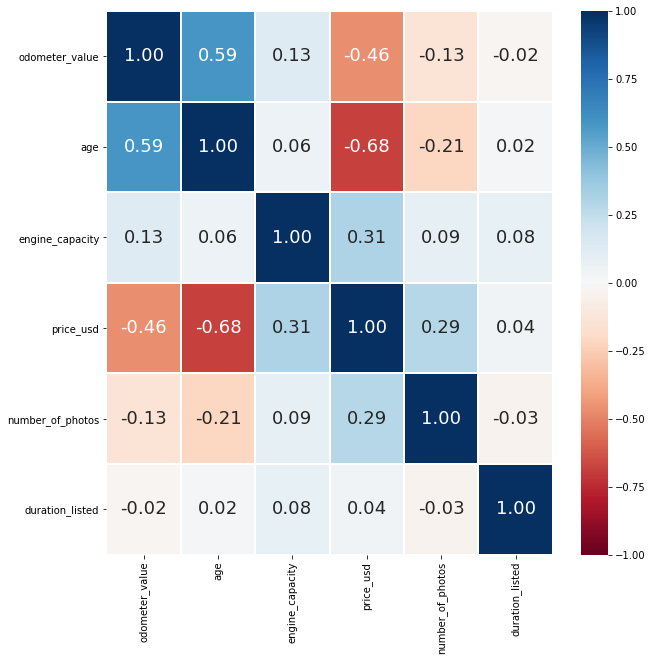

In [ ]:
# Correlation Matrix
print(car_num_shuffled.corr())

# Heatmap of the Correlation Matrix
f, axes = plt.subplots(1, 1, figsize=(10, 10))
sb.heatmap(car_num_shuffled.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

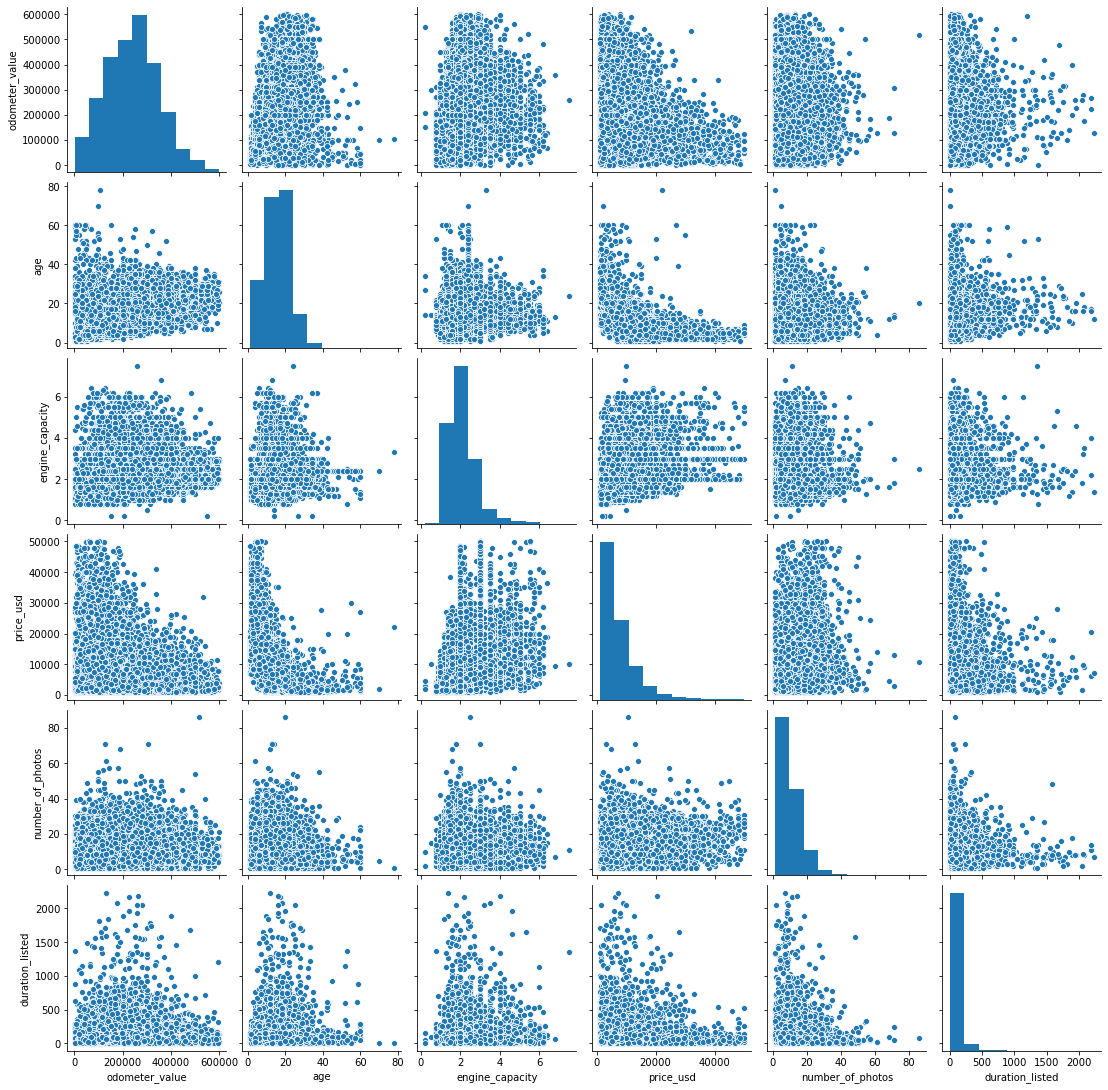

In [ ]:
sb.pairplot(data = car_num_shuffled)

### 2.3 Exploring the categorical data

In [ ]:
#Summary statistics for numeric variables  
car_cat_shuffled.head()

,price_usd,manufacturer_name,model_name,transmission,color,engine_fuel,body_type,drivetrain,location_region
0,2250.0,Opel,Vectra,manual,other,petrol,hatchback,front,Минская обл.
1,2500.0,Citroen,Xantia,manual,black,diesel,hatchback,front,Минская обл.
2,2450.0,Ford,Focus,manual,blue,petrol,sedan,front,Могилевская обл.
3,3700.0,Toyota,Avensis,manual,green,petrol,universal,front,Брестская обл.
4,7500.0,Renault,Scenic,manual,silver,diesel,minivan,front,Витебская обл.


Number of unique manufacturers: 55


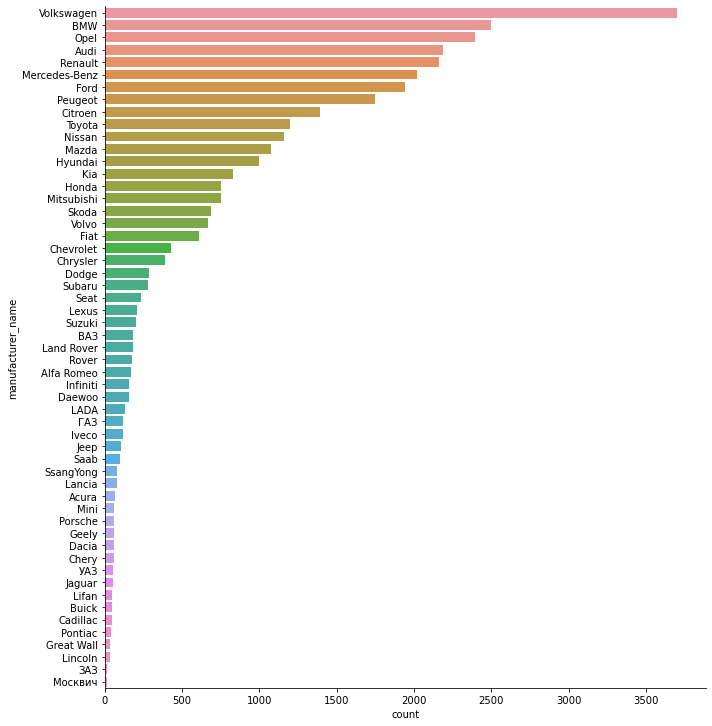

In [ ]:
#Finding number of unique manufacturers
print("Number of unique manufacturers:", len(car_cat_shuffled["manufacturer_name"].unique()))

#Exploring the different manufacturers and the number of cars for each manufacturer in our dataset 
sb.catplot(y = "manufacturer_name", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["manufacturer_name"].value_counts().index, height = 10)

#### Volkswagen seems to be the most common while Москвич is the least, in our dataset

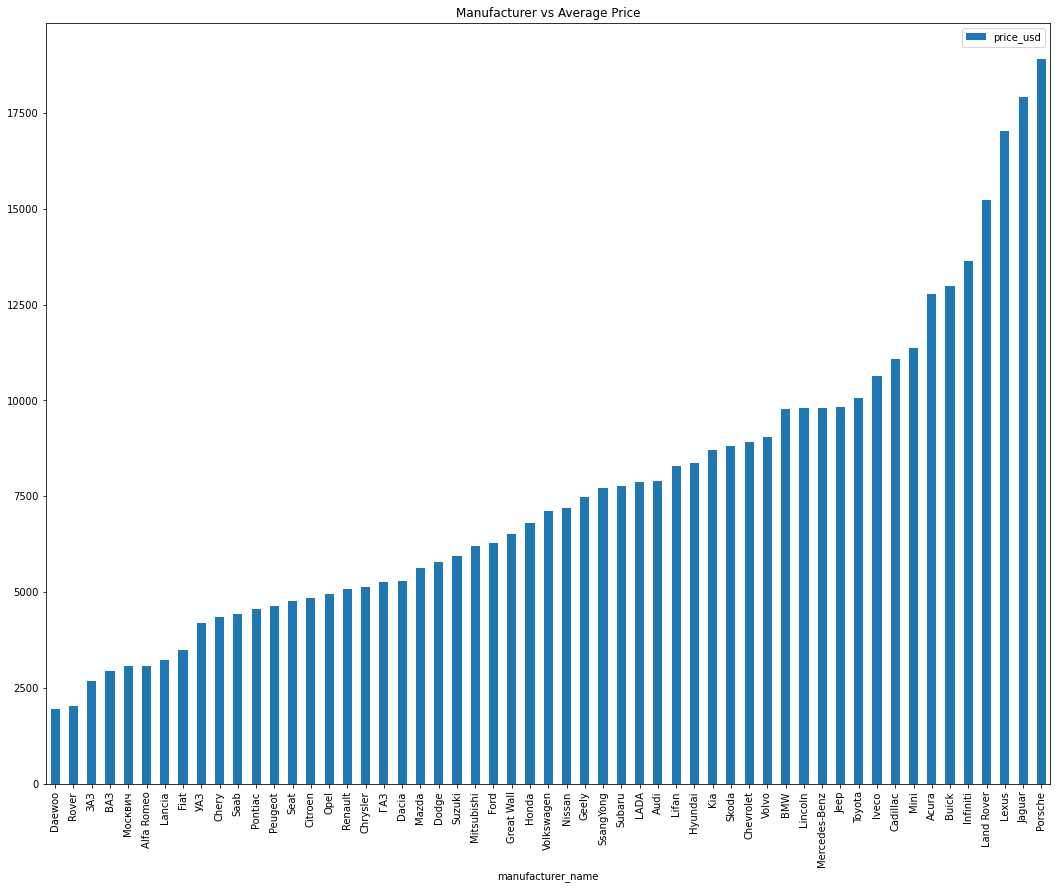

In [ ]:
#Average price of a car by manufacturer
manu_price = pd.DataFrame(car_cat_shuffled.groupby(['manufacturer_name'])['price_usd'].mean().sort_values(ascending = True))
manu_price.plot.bar(figsize=(18, 14))
plt.title('Manufacturer vs Average Price')
plt.show()

#### Average price is the highest for Porsche and lowest for Daewoo

In [ ]:
#Finding number of unique models
print("Number of unique models:", len(car_cat_shuffled["model_name"].unique()))

Number of unique models: 1063


In [ ]:
#Finding number of unique transmission types
print("Number of unique transmission types:", len(car_cat_shuffled["transmission"].unique()))

Number of unique transmission types: 2


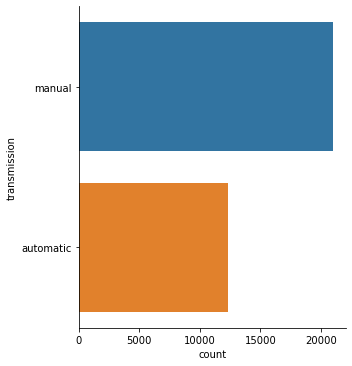

In [ ]:
sb.catplot(y = "transmission", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["transmission"].value_counts().index, height = 5)

Number of unique colours: 12


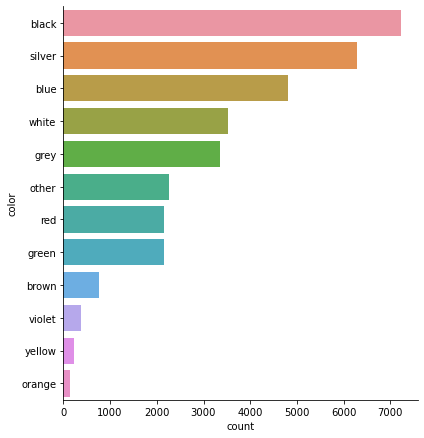

In [ ]:
#Finding number of colours
print("Number of unique colours:", len(car_cat_shuffled["color"].unique()))

#Exploring the number of cars for each colour 
sb.catplot(y = "color", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["color"].value_counts().index, height = 6)

#### Black is the most common and orange the least, in our dataset

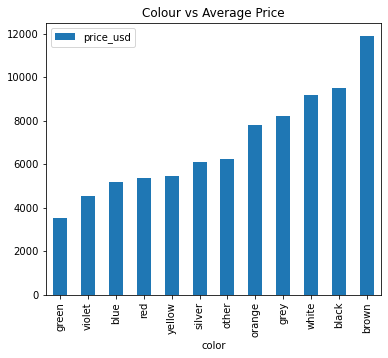

In [ ]:
#Average price of a car by colour
manu_price = pd.DataFrame(car_cat_shuffled.groupby(['color'])['price_usd'].mean().sort_values(ascending = True))
manu_price.plot.bar(figsize=(6, 5))
plt.title('Colour vs Average Price')
plt.show()

#### Brown cars have a greater average price and green cars the least

Number of unique fuel type: 4


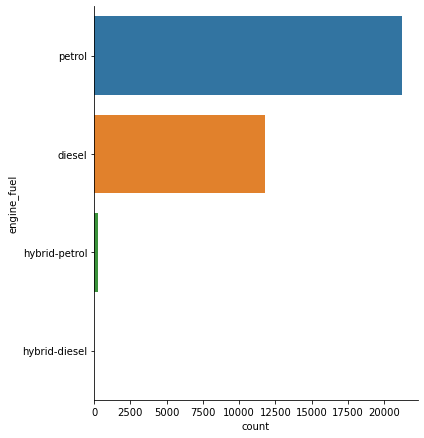

In [ ]:
#Finding number of fuel types
print("Number of unique fuel type:", len(car_cat_shuffled["engine_fuel"].unique()))

#Exploring the number of cars for fuel type 
sb.catplot(y = "engine_fuel", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["engine_fuel"].value_counts().index, height = 6)

#### Gasoline powered cars are most common and hybrid-diesel cars the least, in our dataset

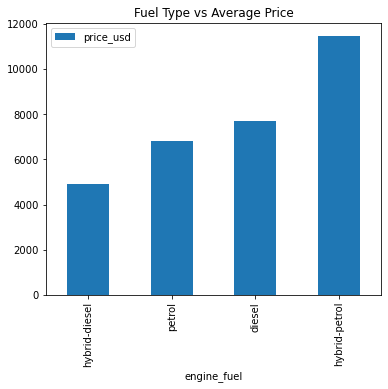

In [ ]:
#Average price of a car by fuel type
manu_price = pd.DataFrame(car_cat_shuffled.groupby(['engine_fuel'])['price_usd'].mean().sort_values(ascending = True))
manu_price.plot.bar(figsize=(6, 5))
plt.title('Fuel Type vs Average Price')
plt.show()

#### Hybrid-petrol cars have the highest average price and hybrid-diesel has the least

Number of unique body types: 12


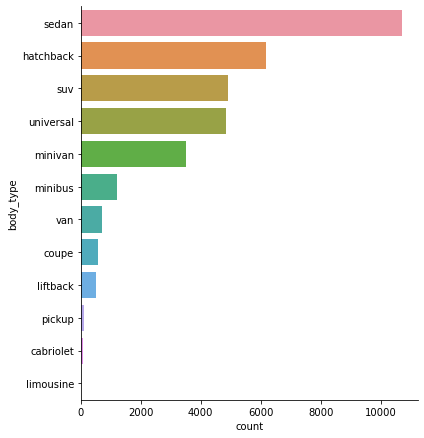

In [ ]:
#Finding number of body types
print("Number of unique body types:", len(car_cat_shuffled["body_type"].unique()))

#Exploring the number of cars for body type 
sb.catplot(y = "body_type", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["body_type"].value_counts().index, height = 6)

#### Sedan is the most common body type and limousine the least

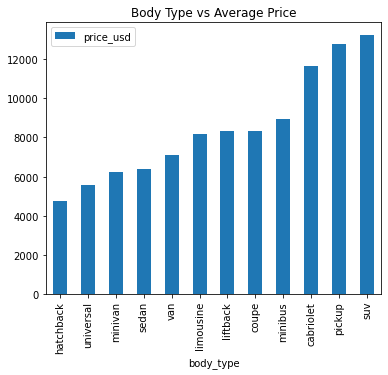

In [ ]:
#Average price of a car by body type
manu_price = pd.DataFrame(car_cat_shuffled.groupby(['body_type'])['price_usd'].mean().sort_values(ascending = True))
manu_price.plot.bar(figsize=(6, 5))
plt.title('Body Type vs Average Price')
plt.show()

#### Average price of an SUV is highest and hatchback the lowest

Number of unique drivetrain types: 3


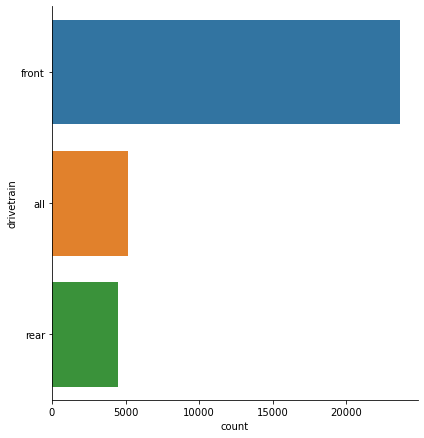

In [ ]:
#Finding number of unique drivetrain types
print("Number of unique drivetrain types:", len(car_cat_shuffled["drivetrain"].unique()))

#Exploring the number of cars for each drivetrain
sb.catplot(y = "drivetrain", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["drivetrain"].value_counts().index, height = 6)

#### Front wheel drive cars are the most common and rear wheel drive the least

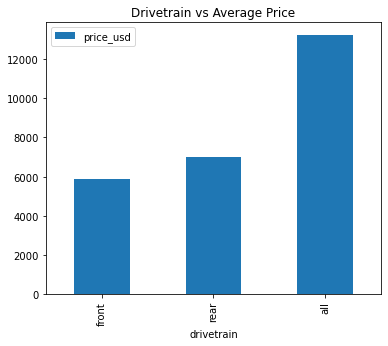

In [ ]:
#Average price of a car by drivetrain
manu_price = pd.DataFrame(car_cat_shuffled.groupby(['drivetrain'])['price_usd'].mean().sort_values(ascending = True))
manu_price.plot.bar(figsize=(6, 5))
plt.title('Drivetrain vs Average Price')
plt.show()

#### All wheel drive cars have the highest average price and front wheel drive cars have the lowest

### Locations against price

Number of unique locations types: 6


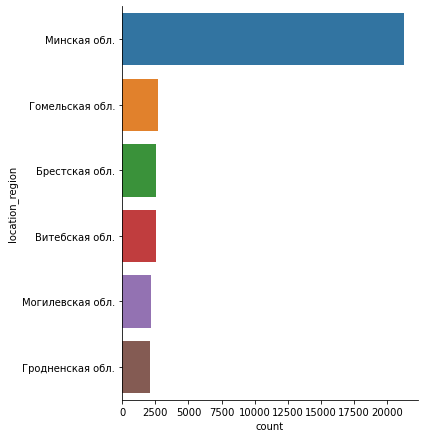

In [ ]:
#Finding number of unique locations
print("Number of unique locations types:", len(car_cat_shuffled["location_region"].unique()))

#Exploring the number of cars for each location
sb.catplot(y = "location_region", data = car_cat_shuffled, kind = "count", 
           order = car_cat_shuffled["location_region"].value_counts().index, height = 6)

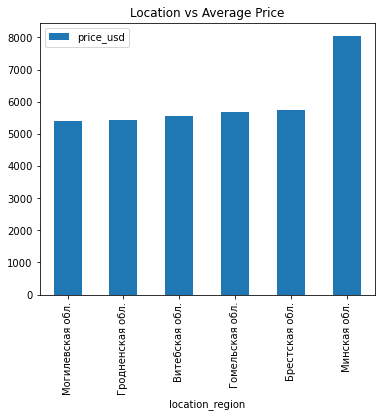

In [ ]:
#Average price of a car by location
manu_price = pd.DataFrame(car_cat_shuffled.groupby(['location_region'])['price_usd'].mean().sort_values(ascending = True))
manu_price.plot.bar(figsize=(6, 5))
plt.title('Location vs Average Price')
plt.show()

# 3.0 : Preparing the data

In [ ]:
# Converting numerical to int type
car_num_shuffled = car_num_shuffled.round(0).astype('int')

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(car_num_shuffled["price_usd"])
X = pd.DataFrame(car_num_shuffled[["odometer_value", "engine_capacity", "age","number_of_photos","duration_listed"]])

In [ ]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes (total number of points, 2368+790=3158)
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (24953, 1) (24953, 5)
Test Set  : (8318, 1) (8318, 5)


# 4.0 : Multi-Variate Regression

### 4.1 : Linear Regression

Intercept of Regression 	: b =  [9851.10865298]
Coefficients of Regression 	: a =  [[-6.55621503e-03  2.64849778e+03 -5.01866190e+02  1.16317307e+02
   1.67875063e+00]]

         Predictors  Coefficients
0    odometer_value     -0.006556
1   engine_capacity   2648.497781
2               age   -501.866190
3  number_of_photos    116.317307
4   duration_listed      1.678751



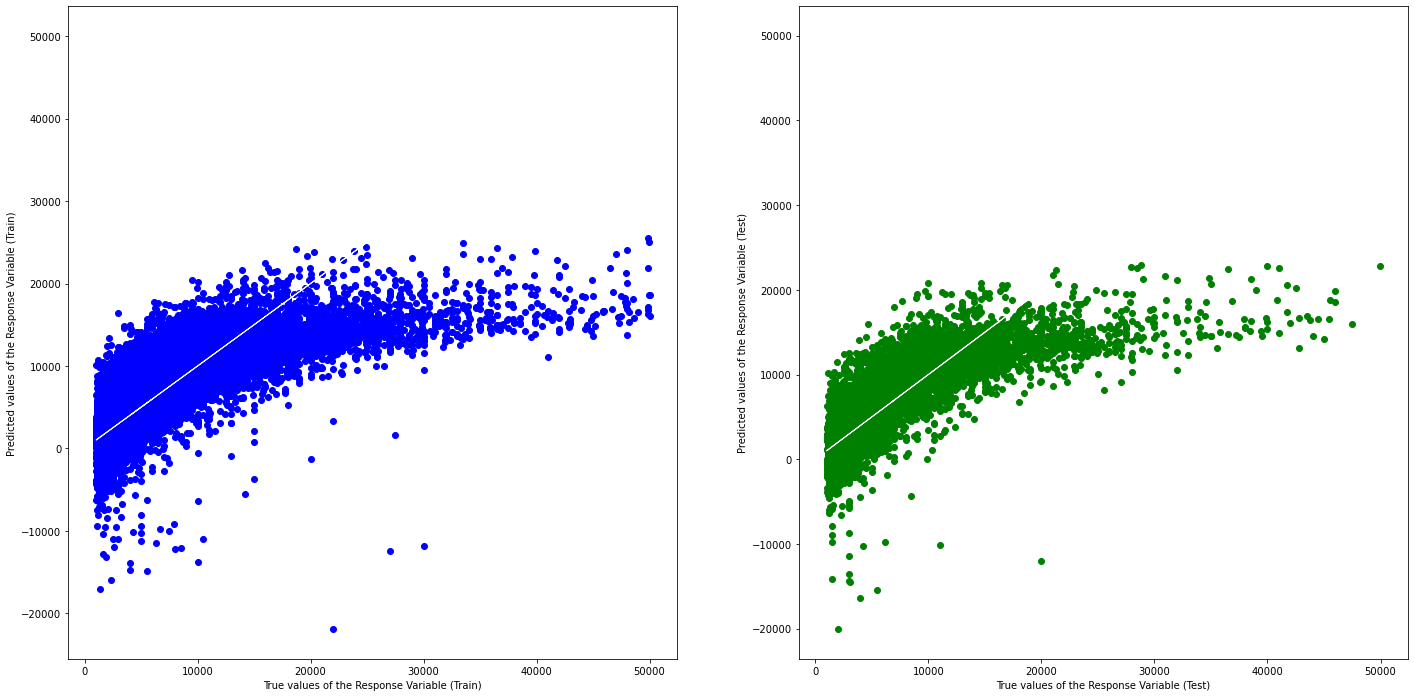

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5860649457434364
Mean Squared Error (MSE) 	: 15456628.11710689
Root Mean Squared Error (RMSE) 	: 3931.4918437034676

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5846205087512888
Mean Squared Error (MSE) 	: 14741773.802365717
Root Mean Squared Error (RMSE) 	: 3839.5017648603466



In [ ]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

### 4.2 : Polynomial Regression

In [ ]:
poly_reg = PolynomialFeatures(degree=2)

X_train_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.fit_transform(X_test)

pol_reg = LinearRegression()
pol_reg.fit(X_train_poly, y_train)

y_train_pred = pol_reg.predict(X_train_poly)
y_test_pred = pol_reg.predict(X_test_poly)

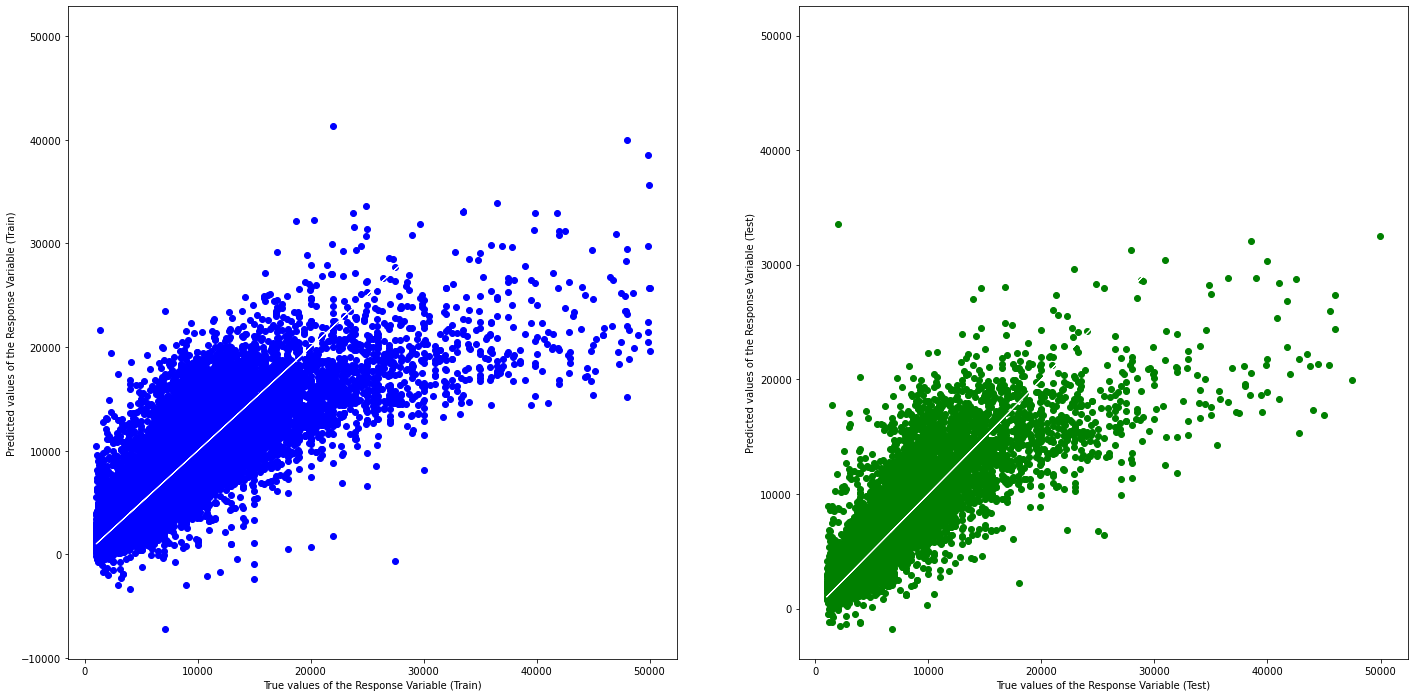

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train,y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test,y_test_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6933965315399622
Mean Squared Error (MSE) 	: 11448790.68025143
Root Mean Squared Error (RMSE) 	: 3383.6061650628653

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6870705349638144
Mean Squared Error (MSE) 	: 11105833.308695093
Root Mean Squared Error (RMSE) 	: 3332.5415689373017



### 4.3 Random Forest Regression with numerical data only

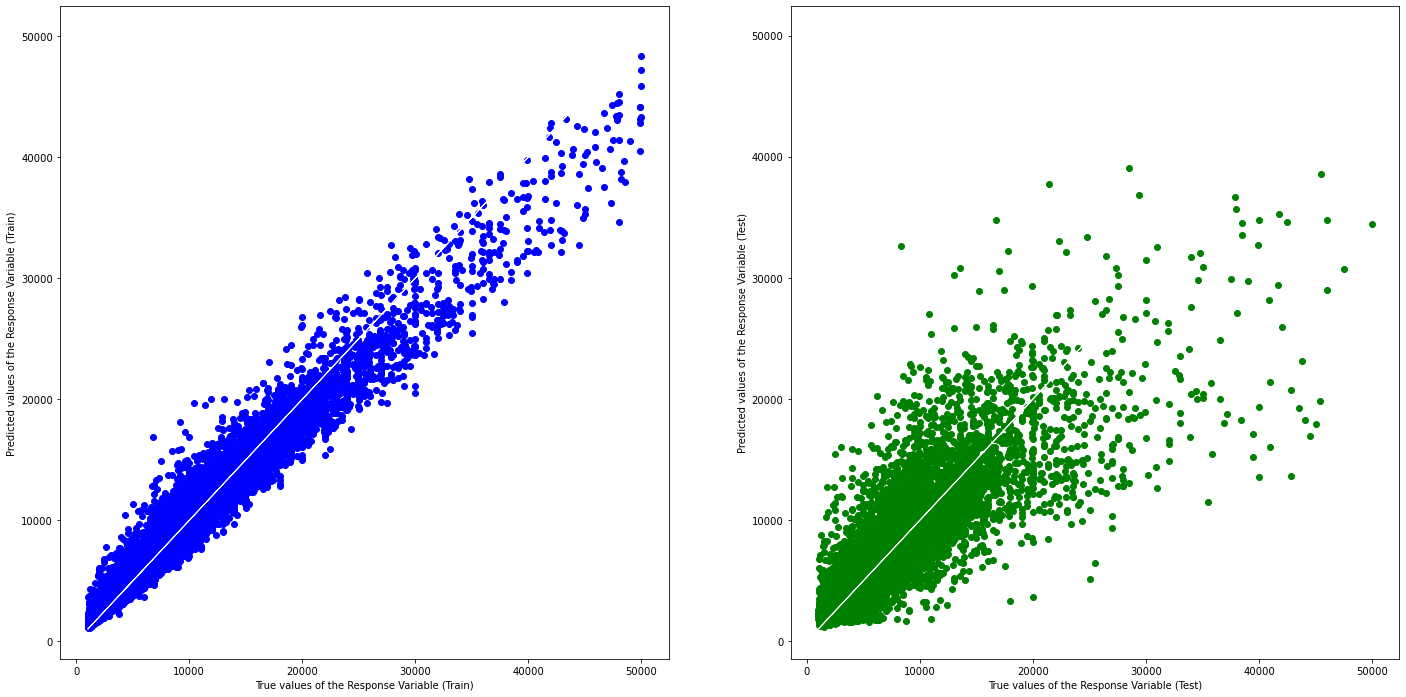

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9605817022645687
Mean Squared Error (MSE) 	: 1471907.157513459
Root Mean Squared Error (RMSE) 	: 1213.2218088682132

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6951992267180073
Mean Squared Error (MSE) 	: 10817346.906082315
Root Mean Squared Error (RMSE) 	: 3288.9735338069104



In [ ]:
rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train.values.ravel())

y_train_pred = rf_reg.predict(X_train)
y_test_pred= rf_reg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rf_reg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rf_reg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

In [ ]:
feature_imp = pd.Series(rf_reg.feature_importances_,index=list(X)).sort_values(ascending=False)
feature_imp

age                 0.598371
engine_capacity     0.142337
odometer_value      0.100860
duration_listed     0.091424
number_of_photos    0.067009
dtype: float64

### 4.4 : Random Forest Regression with "transmission" and "engine_fuel"

In [ ]:
# For RandomForest
y = pd.DataFrame(car_num_shuffled["price_usd"])
X1 = pd.DataFrame(car_shuffled[["odometer_value", "engine_capacity", "age","number_of_photos","duration_listed","transmission","manufacturer_name","body_type","engine_fuel"]])

In [ ]:
X=pd.get_dummies(X1, columns=["transmission","manufacturer_name","body_type","engine_fuel"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

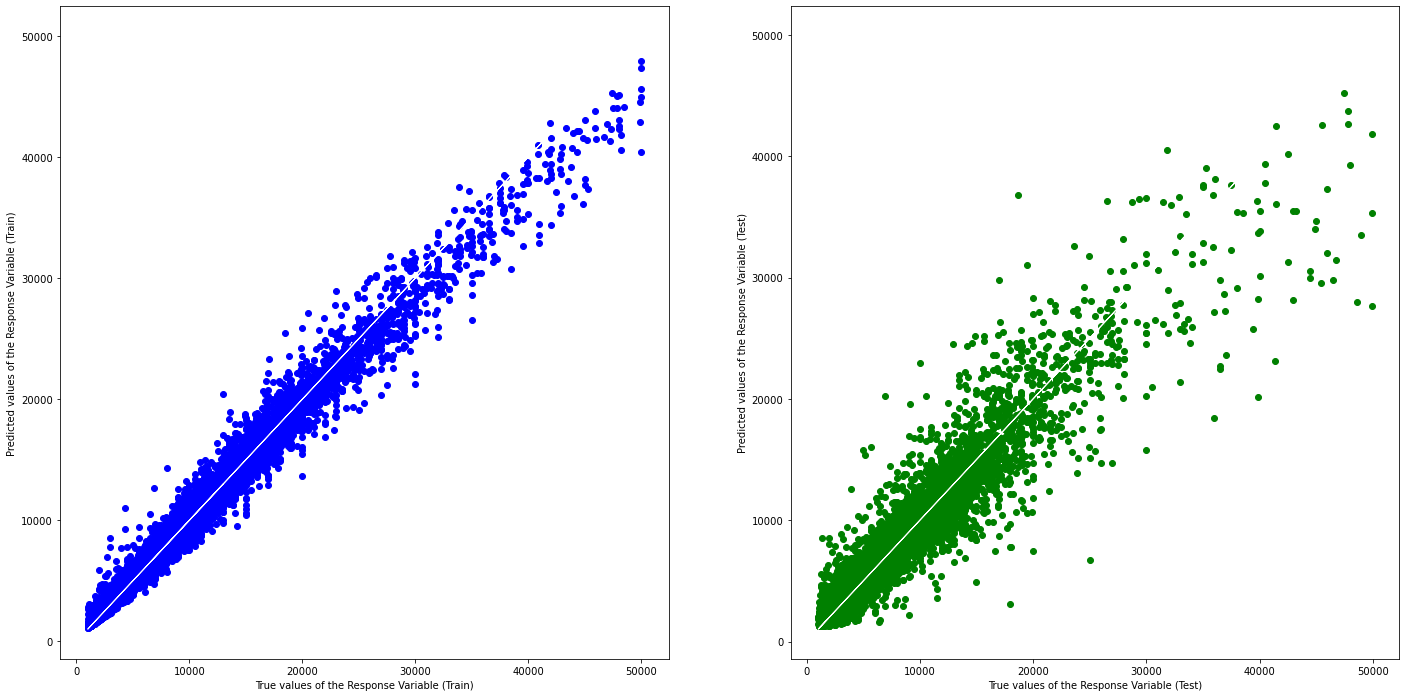

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9848650371050078
Mean Squared Error (MSE) 	: 553783.2276183016
Root Mean Squared Error (RMSE) 	: 744.1661290453238

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8961144627513647
Mean Squared Error (MSE) 	: 3920494.9516704045
Root Mean Squared Error (RMSE) 	: 1980.023977549364



In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train.values.ravel())

y_train_pred = rf_reg.predict(X_train)
y_test_pred= rf_reg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rf_reg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rf_reg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

### 4.5 : XGboost Regression

In [ ]:
y = pd.DataFrame(car_num_shuffled["price_usd"])
X = pd.DataFrame(car_num_shuffled[["odometer_value", "engine_capacity", "age","number_of_photos","duration_listed"]])

In [ ]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

RMSE: 5460.801565


In [ ]:
# Use K-fold method to improve accuracy
params = {"objective":"reg:squarederror",'colsample_bytree': 0.5,'learning_rate': 0.4,
                'max_depth': 6, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
#cv_results contains train and test RMSE metrics for each boosting round.
cv_results.head()
#Note the rmse decreasing with each boosting round

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,6906.541992,20.455381,6928.851725,63.751792
1,5628.440593,253.102100,5677.100423,316.826815
2,5084.676107,230.265896,5166.846517,286.160238
3,4598.240235,332.960616,4703.475423,389.523954
4,4297.017171,513.448161,4417.991048,572.463825


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))
#Note the decrease in RMSE from 5835 to 3881, an improvement of about 35% after parameter tuning and using k-fold

49    3266.769368
Name: test-rmse-mean, dtype: float64


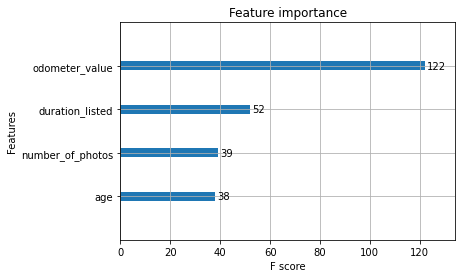

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30,10]
plt.show()

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=15)

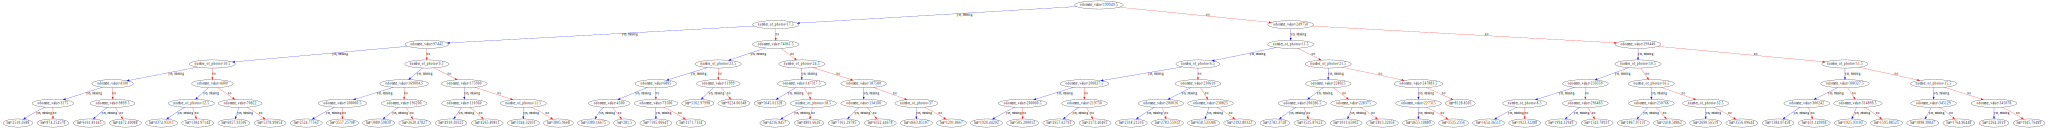

In [ ]:
xgb.to_graphviz(xg_reg)